In [145]:
# importing neccessary python packages needed to run the the model

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPool2D, Dropout, GlobalAveragePooling2D, Rescaling

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.6.0


In [70]:
# using the distutils.dir_util for Directory tree operations 
# This module provides functions for operating on directories and trees of directories

base_dir = "/Users/aElias/Library/CloudStorage/OneDrive-Personal/MSc Program/AD-Classification-Network/divided_data/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['.DS_Store', 'VeryMildDemented', 'ModerateDemented', '__init__.py', 'MildDemented', 'NonDemented']


In [71]:
# declaring the dataset pathway

WORK_DIR = './dataset/'

# declaring and defining the 4 classes used in the model 

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

# redefining the images sizes and dim for the input model

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [72]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

# using the keras preprocessing.image.imageDatagenerator for to generate batches of tensor
# image data with real-time data augmentation 
work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
# Keras’ ImageDataGenerator class allows the users to perform 
# image augmentation while training the model.
# the flow_from_directory() method takes a path of a directory and generates batches of augmented data
train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


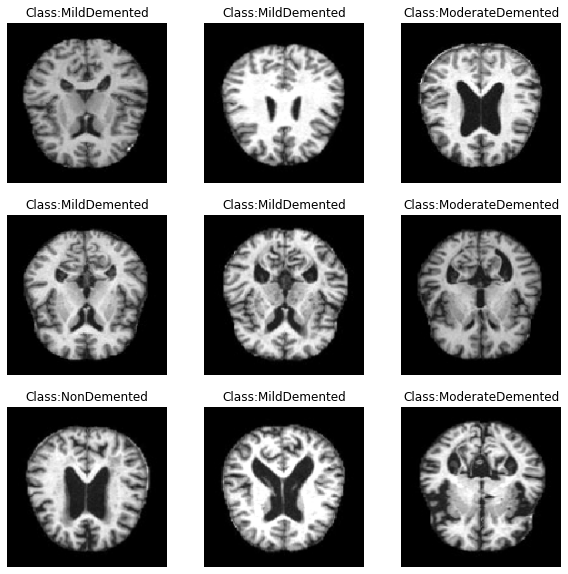

In [73]:
# plotting images found in the datasets path for visual purposes 

def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images

show_images(train_data_gen)

In [74]:
# Retrieving the data from the ImageDataGenerator iterator
# setting the training data and training labels

train_data, train_labels = train_data_gen.next()

In [75]:
# print the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [76]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
# reshapping the dimensions of our datasets 
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
# check the dimensions of our datasets after over sampling 
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [77]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [150]:
# using the keras methods to define our convolutional neural layer

def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    # print(block.summary())
    
    return block
# conv_block(64)

In [157]:
# using keras methods to define the LSTM layer
# note this layer is not used in the model systems, just for testing purposes

def lstm_block(filters, shape):
    block = Sequential()
    block.add(LSTM(filters))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    return block
    

In [123]:
# defining the fully connected layer

def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

## Deep laying Architechure model 

In [168]:

# designing the model architecture 
# input layer 
# convolutional layer 
# fully connected layer 
# activation functions are included in the functions defination 

def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

In [163]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [169]:
#Defining other parameters for our CNN model

model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_182 (Conv2D)          (None, 176, 176, 16)      448       
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 176, 176, 16)      2320      
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 88, 88, 16)        0         
_________________________________________________________________
sequential_76 (Sequential)   (None, 44, 44, 32)        14016     
_________________________________________________________________
sequential_77 (Sequential)   (None, 22, 22, 64)        55680     
_________________________________________________________________
sequential_78 (Sequential)   (None, 11, 11, 128)       221952    
_________________________________________________________________
dropout_73 (Dropout)         (None, 11, 11, 128)       0 

In [191]:
# def define_model_1():
#     act = 'relu'
#     model = Sequential()
#     model.add(Input(shape=(*IMAGE_SIZE, 3)))
#     model.add(Conv2D(16, 3, activation=act, padding='same'))
#     model.add(Conv2D(16, 3, activation=act, padding='same'))
#     model.add(MaxPool2D())
#     model.add(Conv2D(32, 3, activation=act, padding='same'))
#     model.add(Conv2D(32, 3, activation=act, padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D())
#     model.add(Conv2D(64, 3, activation=act, padding='same'))
#     model.add(Conv2D(64, 3, activation=act, padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D())
#     model.add(Conv2D(128, 3, activation=act, padding='same'))
#     model.add(Conv2D(128, 3, activation=act, padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D())
#     model.add(Dropout(0.2))
#     model.add(Conv2D(256, 3, activation=act, padding='same'))
#     model.add(Conv2D(256, 3, activation=act, padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D())
#     model.add(Dropout(0.2))
#     model.add(Flatten())
#     model.add(Dense(512, activation=act))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.7))
#     model.add(Dense(128, activation=act))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
#     model.add(Dense(64, activation=act))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))
#     # model.add(LSTM(64, input_shape=(None,64), return_sequences=False))
#     model.add(Dense(4, activation='sigmoid') )
    
#     return model

# model = define_model_1()

## shallow Deep laying architechure 

In [203]:
def define_model_2():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu', input_shape=(176, 176, 3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(176, 176, 3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (2, 2), padding="same", activation='relu', input_shape=(176, 176, 3)))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    # model.compile(optimizer="Adam",
    #               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    #               metrics=["accuracy"])
    return model

model = define_model_2()

In [204]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_382 (Conv2D)          (None, 176, 176, 64)      1792      
_________________________________________________________________
max_pooling2d_192 (MaxPoolin (None, 88, 88, 64)        0         
_________________________________________________________________
conv2d_383 (Conv2D)          (None, 88, 88, 32)        18464     
_________________________________________________________________
max_pooling2d_193 (MaxPoolin (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_384 (Conv2D)          (None, 44, 44, 32)        4128      
_________________________________________________________________
max_pooling2d_194 (MaxPoolin (None, 22, 22, 32)        0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 15488)          

# Training and Testing 

In [205]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 10

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/10
256/256 [==============================] - 243s 943ms/step - loss: 0.8821 - acc: 0.5767 - auc: 0.8519 - f1_score: 0.5724 - val_loss: 0.6149 - val_acc: 0.7266 - val_auc: 0.9310 - val_f1_score: 0.7094
Epoch 2/10
256/256 [==============================] - 284s 1s/step - loss: 0.4891 - acc: 0.7789 - auc: 0.9557 - f1_score: 0.7773 - val_loss: 0.4007 - val_acc: 0.8271 - val_auc: 0.9709 - val_f1_score: 0.8247
Epoch 3/10
256/256 [==============================] - 275s 1s/step - loss: 0.3213 - acc: 0.8666 - auc: 0.9810 - f1_score: 0.8658 - val_loss: 0.3428 - val_acc: 0.8540 - val_auc: 0.9778 - val_f1_score: 0.8516
Epoch 4/10
256/256 [==============================] - 286s 1s/step - loss: 0.2085 - acc: 0.9163 - auc: 0.9915 - f1_score: 0.9160 - val_loss: 0.2573 - val_acc: 0.9004 - val_auc: 0.9877 - val_f1_score: 0.8973
Epoch 5/10
256/256 [==============================] - 259s 1s/step - loss: 0.1065 - acc: 0.9602 - auc: 0.9976 - f1_score: 0.9602 - val_loss: 0.2270 - val_acc: 0.9209 - v

### Results and Evaluation

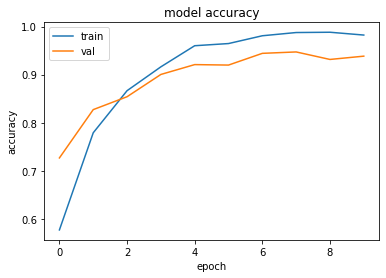

In [215]:
from matplotlib import pyplot as plt
# history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

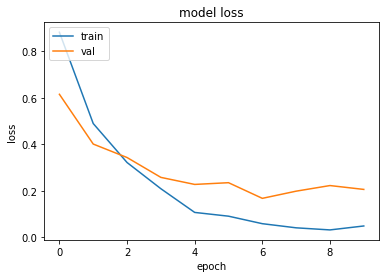

In [216]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [207]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 16s 201ms/step - loss: 0.2317 - acc: 0.9355 - auc: 0.9897 - f1_score: 0.9355
Testing Accuracy: 93.55%


In [208]:
#Predicting the test data

pred_labels = model.predict(test_data)

In [210]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.96      0.98      0.97       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.95      0.83      0.89       662
ModerateDemented       0.84      0.93      0.89       624

       micro avg       0.94      0.94      0.94      2560
       macro avg       0.94      0.94      0.94      2560
    weighted avg       0.94      0.94      0.94      2560
     samples avg       0.94      0.94      0.94      2560



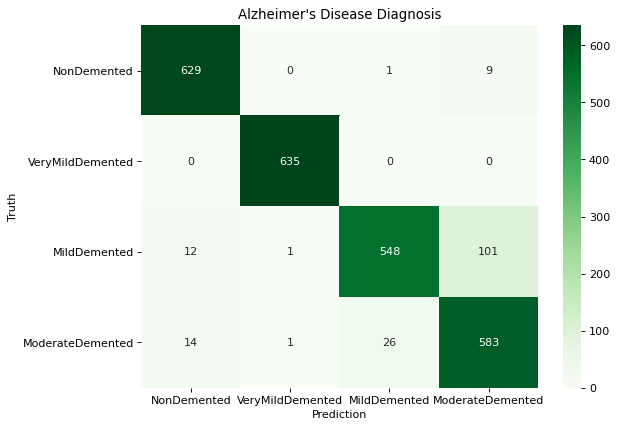

In [211]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [212]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 93.66 %
Matthew's Correlation Coefficient: 91.53 %


In [213]:
#Saving the model for future use

model_dir = work_dir + "alzheimer_cnn_model"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['.DS_Store',
 'VeryMildDemented',
 'ModerateDemented',
 'alzheimer_cnn_model',
 'model_plot.png',
 '__init__.py',
 'MildDemented',
 'NonDemented']

## model Layer Architecture 

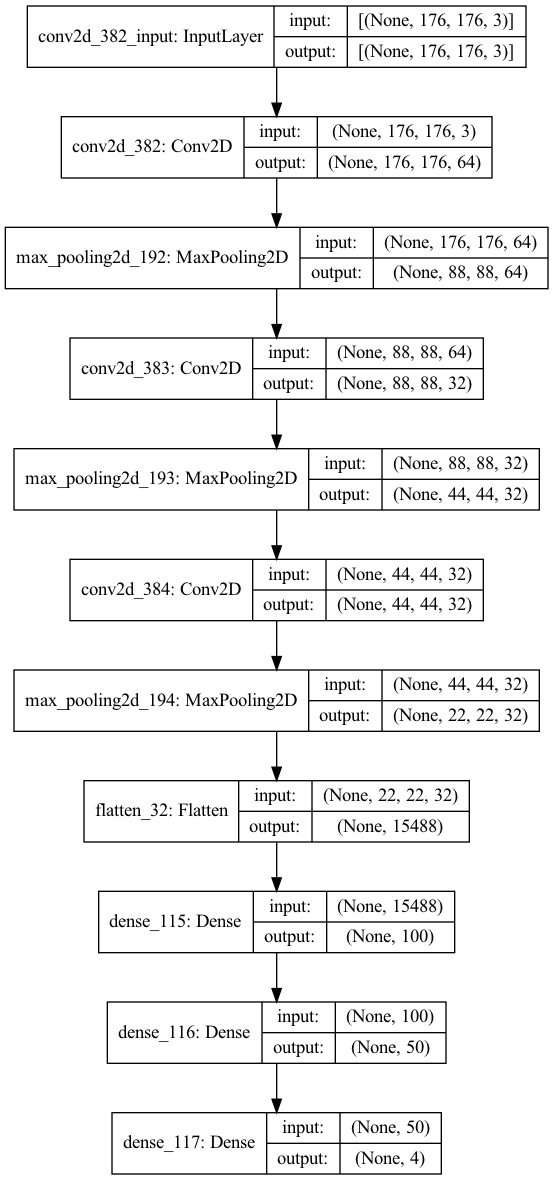

In [214]:
pretrained_model = tf.keras.models.load_model(model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)